### Classificação: Estudo de caso sobre vendas

**1.1 Importando as bibliotecas básicas**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**1.2 Importando o conjunto de dados**

In [2]:
df = pd.read_csv("vendas.csv")

**1.3 Vamos assumir que todo o processamento de dados já foi realizado previamente**

**1.4 Divida os dados em X e y**

In [3]:
target = 'Revenue'
X = df.drop(columns = target)
y = df[target].values

**1.5 Codificação de dados categóricos**

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [5]:
colunas_categoricas = ['Month', 'OperatingSystems', 'Browser', 'TrafficType', 'VisitorType', 'Weekend']

# Espeficica o método a ser aplicado
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(drop='first' , sparse_output=False), colunas_categoricas)],
    remainder='passthrough'
)

# Aplicamos a codificação e a salvamos em uma variável chamada X_array
X_array = ct.fit_transform(X)

# Recupera os nomes das colunas transformadas
colunas_finais = ct.get_feature_names_out()

# Converte para DataFrame mantendo os índices originais
X_df = pd.DataFrame(X_array, columns=colunas_finais, index=X.index)

**1.6 Dividir o conjunto de dados em dados de treinamento e de teste**

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state=42)

**1.7 Padronização das colunas numéricas**

In [8]:
from sklearn.preprocessing import RobustScaler

In [9]:
# 1. Selecionar colunas numéricas contínuas, ou seja, que não são dummies (OneHotEncoder)

colunas_numericas = [col for col in X_df.columns if not col.startswith('one_hot_encoder__')]

# 2. Criar o ColumnTransformer usando os nomes diretamente

ct = ColumnTransformer(
    [('escalar', RobustScaler(), colunas_numericas)],
    remainder='passthrough'
)

# 3. Ajustar e transformar os dados de treino
X_train_scaled = ct.fit_transform(X_train)

# 4. Aplicar a mesma transformação aos dados de teste
X_test_scaled = ct.transform(X_test)

# 5. Obter os nomes finais das colunas após transformação
columns_final_scaled = ct.get_feature_names_out()

# 6. Converter em DataFrames com os nomes corretos
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns_final_scaled, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns_final_scaled, index=X_test.index)

**1.8 Há variáveis que não são importantes no modelo?**

In [11]:
import statsmodels.api as sm

**Uma função que deixa no modelo final apenas variáveis relevantes:**

In [12]:
def backward_elimination(X, y, sl=0.05):
    
    X_with_const = sm.add_constant(X)  # adiciona uma constante
    cols = list(X_with_const.columns)
    while True:
        model = sm.Logit(y, X_with_const[cols]).fit(disp=0)
        p_values = model.pvalues
        max_p = p_values.max()
        if max_p > sl:
            excluded_feature = p_values.idxmax()
            if excluded_feature == 'const':
                break
            cols.remove(excluded_feature)
        else:
            break
    final_model = sm.Logit(y, X_with_const[cols]).fit(disp=0)
    return final_model, X[cols[1:]]  # remove uma constante

In [13]:
final_model, X_selecionado = backward_elimination(X_train_scaled, y_train)

In [14]:
print(final_model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9826
Model:                          Logit   Df Residuals:                     9814
Method:                           MLE   Df Model:                           11
Date:                Fri, 09 May 2025   Pseudo R-squ.:                  0.3174
Time:                        10:55:16   Log-Likelihood:                -2901.9
converged:                       True   LL-Null:                       -4251.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                        -2.6893      0.110    -24.400      0.000      -2.905   

## Regressão logística

**2.1 Treinando o modelo**

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# Instanciar o modelo
modelo_log = LogisticRegression(solver='liblinear')

In [17]:
# Lembre-se que vamos usar apenas as variáveis (colunas) com p < 0.05
# Esses são os nomes dos conjuntos de dados finais

X_train_final = X_train_scaled[X_selecionado.columns]
X_test_final = X_test_scaled[X_selecionado.columns]

In [18]:
# Treinando os dados
modelo_log.fit(X_train_final, y_train)

LogisticRegression(solver='liblinear')

**2.2 Os dados usados predizem bem y?**

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
# Desempenho no conjunto de treinamento
y_train_predito = modelo_log.predict(X_train_final)
acuracia_treinamento = accuracy_score(y_train, y_train_predito)
print(f"Acuracia do conjunto de treinamento: {acuracia_treinamento}")

print("\n")

# Desempenho no conjunto de teste
y_test_predito = modelo_log.predict(X_test_final)
acuracia_teste = accuracy_score(y_test, y_test_predito)
print(f"Acuracia do conjunto de teste: {acuracia_teste}")

Acuracia do conjunto de treinamento: 0.8825564828007327


Acuracia do conjunto de teste: 0.8803418803418803


**2.3 Matriz de confusão**

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
cm = confusion_matrix(y_test, y_test_predito)

print('Matriz de confusão\n\n', cm)
print('\n')

print('Verdadeiros negativos (TN):', cm[0, 0])
print('Falsos positivos (FP):    ', cm[0, 1])
print('Falsos negativos (FN):    ', cm[1, 0])
print('Verdadeiros positivos (TP):', cm[1, 1])

Matriz de confusão

 [[2032   48]
 [ 246  131]]


Verdadeiros negativos (TN): 2032
Falsos positivos (FP):     48
Falsos negativos (FN):     246
Verdadeiros positivos (TP): 131


**2.4 Métricas de classificação**

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, y_test_predito))

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      2080
        True       0.73      0.35      0.47       377

    accuracy                           0.88      2457
   macro avg       0.81      0.66      0.70      2457
weighted avg       0.87      0.88      0.86      2457



**2.5 Ajustando o limiar de classificação**

Vamos testar diferentes valores de limiar de classificação:

**Passo1: Obter as probabilidades preditas da classe positiva --->**

In [25]:
y_probs = modelo_log.predict_proba(X_test_final)[:, 1]  # probabilidade de classe 1 (compra)
y_probs.mean()

np.float64(0.15157739106462137)

**Passo 2: Vamos simular diferentes valores --->**

In [26]:
from sklearn.metrics import recall_score

In [27]:
for valor in np.arange(0.1, 0.9, 0.1):
    y_test_predito = (y_probs >= valor).astype(int)
    recall = recall_score(y_test, y_test_predito)
    print(f"Limiar: {valor:.1f} | Recall classe 1: {recall:.3f}")

Limiar: 0.1 | Recall classe 1: 0.912
Limiar: 0.2 | Recall classe 1: 0.663
Limiar: 0.3 | Recall classe 1: 0.523
Limiar: 0.4 | Recall classe 1: 0.422
Limiar: 0.5 | Recall classe 1: 0.347
Limiar: 0.6 | Recall classe 1: 0.294
Limiar: 0.7 | Recall classe 1: 0.257
Limiar: 0.8 | Recall classe 1: 0.215


**2.6 Curva ROC**

**Acessa a performance do modelo para cada limiar de classificação**

In [28]:
from sklearn.metrics import roc_curve

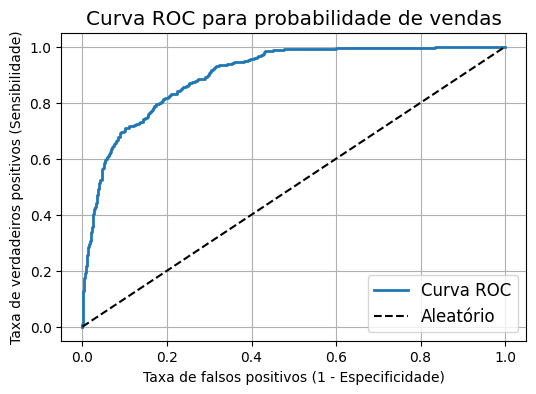

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=True)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, linewidth=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.rcParams['font.size'] = 12

plt.title('Curva ROC para probabilidade de vendas')
plt.xlabel('Taxa de falsos positivos (1 - Especificidade)')
plt.ylabel('Taxa de verdadeiros positivos (Sensibilidade)')
plt.legend()
plt.grid(True)
plt.show()

**2.7 Calcular área sob a curva ROC - AUC**

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
ROC_AUC = roc_auc_score(y_test, y_probs)
print(ROC_AUC)

0.9017279636808815


**2.8 Validação cruzada**

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
scores = cross_val_score(modelo_log, X_train_final, y_train, cv = 5, scoring='accuracy')
print(f"Scores de validação cruzada: {scores}")

Scores de validação cruzada: [0.88708037 0.88498728 0.88244275 0.87582697 0.88040712]


**2.9 Otimização com hiperparâmetros**

In [34]:
from sklearn.model_selection import GridSearchCV

**Testando diferentes ajustes de regularização e penalização:**

In [35]:
parametros = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

grid = GridSearchCV(estimator = modelo_log,  
                           param_grid = parametros,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid.fit(X_train_final, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [36]:
print("Melhores hiperparâmetros:", grid.best_params_)
print("Melhor acurácia média em CV:", grid.best_score_)

# Modelo ajustado com os melhores hiperparâmetros:
melhor_modelo = grid.best_estimator_

Melhores hiperparâmetros: {'penalty': 'l2'}
Melhor acurácia média em CV: 0.8821488976726488


**2.10 Escolher um novo limiar de classificação:**

In [37]:
threshold = 0.3
y_pred_adjusted = (y_probs >= threshold).astype(int)

**21. Avaliar o desempenho do modelo novamente**

In [38]:
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_adjusted))
print("Reporte de classificação:\n", classification_report(y_test, y_pred_adjusted))

Matriz de confusão:
 [[1987   93]
 [ 180  197]]
Reporte de classificação:
               precision    recall  f1-score   support

       False       0.92      0.96      0.94      2080
        True       0.68      0.52      0.59       377

    accuracy                           0.89      2457
   macro avg       0.80      0.74      0.76      2457
weighted avg       0.88      0.89      0.88      2457



### K-NN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

**3.1 Treinar o modelo com diferentes valores de K**

In [42]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21)}

grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_final, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"O valor ótimo de vizinhos é: {optimal_k}")

O valor ótimo de vizinhos é: 15


**3.2 Treinar o modelo final com o melhor K:**

In [43]:
final_knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
final_knn.fit(X_train_final, y_train)

KNeighborsClassifier(n_neighbors=15, weights='distance')

**3.3 Avaliar o resultado no conjunto de teste:**

In [44]:
y_predito_knn = final_knn.predict(X_test_final)

**3.4 Matriz de confusão**

In [45]:
cm = confusion_matrix(y_test, y_predito_knn)

print('Matriz de confusão\n\n', cm)
print('\n')

Matriz de confusão

 [[1968  112]
 [ 181  196]]




**3.5 Há sobreajuste ou subajuste?**

In [46]:
# Avaliar o desempenho no conjunto de treinamento
y_pred_train = final_knn.predict(X_train_final)
acc_train = accuracy_score(y_train, y_pred_train)
print(f"Treino: {acc_train:}")

print("\n")

# Avaliar o desempenho no conjunto de teste
acc_test = accuracy_score(y_test, y_predito_knn)
print(f"Teste: {acc_test:}")

Treino: 0.9986769794422959


Teste: 0.8807488807488808


**3.6 Métricas de classificação**

In [47]:
print(classification_report(y_test, y_predito_knn))

              precision    recall  f1-score   support

       False       0.92      0.95      0.93      2080
        True       0.64      0.52      0.57       377

    accuracy                           0.88      2457
   macro avg       0.78      0.73      0.75      2457
weighted avg       0.87      0.88      0.88      2457



**3.7 Validação cruzada**

In [48]:
scores = cross_val_score(final_knn, X_train_final, y_train, cv = 5, scoring='accuracy')
print(f"Scores de validação cruzada: {scores}")

Scores de validação cruzada: [0.88606307 0.88549618 0.88498728 0.88142494 0.87888041]


**Repete-se todo o processo de validação do modelo**

### Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

**4.1 Treinar o modelo**

In [53]:
# Instanciar o modelo
gnb = GaussianNB()

#Ajustar o modelo
gnb.fit(X_train_final, y_train)


GaussianNB()

**4.2 Predizer os resultados**

In [54]:
y_pred = gnb.predict(X_test_final)

y_pred

array([False, False, False, ..., False, False, False])

**4.3 Avaliar a acurácia**

In [55]:
# Desempenho no conjunto de treinamento
y_train_predito = gnb.predict(X_train_final)
acuracia_treinamento = accuracy_score(y_train, y_train_predito)
print(f"Acuracia do conjunto de treinamento: {acuracia_treinamento}")

print("\n")

# Desempenho no conjunto de teste
y_test_predito = gnb.predict(X_test_final)
acuracia_teste = accuracy_score(y_test, y_test_predito)
print(f"Acuracia do conjunto de teste: {acuracia_teste}")

Acuracia do conjunto de treinamento: 0.8191532668430694


Acuracia do conjunto de teste: 0.8066748066748066


**4.4 Matriz de confusão**

In [56]:
cm = confusion_matrix(y_test, y_test_predito)

print('Matriz de confusão\n\n', cm)
print('\n')

print('Verdadeiros negativos (TN):', cm[0, 0])
print('Falsos positivos (FP):    ', cm[0, 1])
print('Falsos negativos (FN):    ', cm[1, 0])
print('Verdadeiros positivos (TP):', cm[1, 1])

Matriz de confusão

 [[1774  306]
 [ 169  208]]


Verdadeiros negativos (TN): 1774
Falsos positivos (FP):     306
Falsos negativos (FN):     169
Verdadeiros positivos (TP): 208


**4.5 Métricas de classificação**

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.85      0.88      2080
        True       0.40      0.55      0.47       377

    accuracy                           0.81      2457
   macro avg       0.66      0.70      0.67      2457
weighted avg       0.84      0.81      0.82      2457



**4.6 Validação cruzada**

In [58]:
scores = cross_val_score(gnb, X_train_final, y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.82299084 0.82807731 0.80671414 0.82299084 0.80467955 0.8138352
 0.81466395 0.82892057 0.80651731 0.83808554]


### Rede Neural

**5.1 Importar tensorflow:**

In [59]:
import tensorflow as tf

C:\Users\Paulo\anaconda3\envs\neural\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Vamos trabalhar com todas as variáveis iniciais (33 colunas)

In [53]:
X_train_scaled.shape

(9826, 33)

**5.2 Iniciar a rede neural**

In [60]:
ann = tf.keras.models.Sequential()

**5.3 Adicionar a camada de entrada e a primeira camada oculta**

**Quantos nós deve ter a primeira camada oculta?**

In [61]:
ann.add(tf.keras.layers.Dense(units=17, activation='relu'))

**5.4 Adicionar a segunda camada oculta**

In [62]:
ann.add(tf.keras.layers.Dense(units=17, activation='relu'))

**5.5 Adicionar a camada de saída**

In [63]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

**5.6 Compilar a rede neural**

In [64]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

**5.7 Treinar a rede neural com o conjunto de treinamento**

In [68]:
ann.fit(X_train_scaled, y_train, batch_size = 64, epochs = 100)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8398 - loss: 0.9802 
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3068 
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.2761 
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8935 - loss: 0.2709 
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.2635 
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.2534 
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.2555 
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8870 - loss: 0.2697 
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8890 - loss: 0.2732 
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.2493 
Epoch 11/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8948 - loss: 0.2515 
Epoch 12/100
154/154 ━━━━━━━━━

**5.8 Predizer os resultados no conjunto de teste**

In [71]:
y_pred_ann = ann.predict(X_test_scaled)
y_pred_classes = (y_pred_ann > 0.5).astype(int)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


**5.9 Matriz de confusão**

In [72]:
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[1961  119]
 [ 149  228]]


**5.10 Acurácia**

In [73]:
accuracy_score(y_test, y_pred_classes)

0.8909238909238909

**5.11 Métricas de classificação**

In [74]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

       False       0.93      0.94      0.94      2080
        True       0.66      0.60      0.63       377

    accuracy                           0.89      2457
   macro avg       0.79      0.77      0.78      2457
weighted avg       0.89      0.89      0.89      2457

